Important notes on libaries: sf and dplyr (and dependencies) were installed using anaconda.
dggridR was originally installed from CRAN using R but has since been archived.
To instal dggridR download the tar.gz and install from that rather than CRAN.

In [1]:
library(sf)

Linking to GEOS 3.9.1, GDAL 3.2.1, PROJ 8.0.0



In [2]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
library(dggridR)

Loading required package: rgdal

Loading required package: sp

rgdal: version: 1.5-16, (SVN revision 1050)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.2.1, released 2020/12/29
Path to GDAL shared files: /Users/amandabousquin/opt/anaconda3/envs/R_hex_jupyter/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 8.0.0, March 1st, 2021, [PJ_VERSION: 800]
Path to PROJ shared files: /Users/amandabousquin/opt/anaconda3/envs/R_hex_jupyter/share/proj
PROJ CDN enabled: TRUE
Linking to sp version:1.4-5
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.

Loading required package: ggplot2



In [4]:
# Read station points from getWQP to sf
git_url = 'https://github.com/USEPA/Coastal_Ecological_Indicators/raw/master/DGGS_Coastal/temperature_data'
# Original source:
station_points <- paste(git_url, "Temperature_Stations.geojson", sep='/')
# Read geojson to sf
station.sf <- st_read(station_points)

Reading layer `Temperature_Stations' from data source `https://github.com/USEPA/Coastal_Ecological_Indicators/raw/master/DGGS_Coastal/temperature_data/Temperature_Stations.geojson' using driver `GeoJSON'
Simple feature collection with 9034 features and 5 fields
geometry type:  POINT
dimension:      XY
bbox:           xmin: -82.74582 ymin: 27.49433 xmax: -82.37482 ymax: 28.12513
geographic CRS: WGS 84


In [5]:
# Inspect different DGGS by changing target area
dggs <- dgconstruct(projection="FULLER", aperture = 4, area=22)

Resolution: 11, Area (km^2): 12.1609120780012, Spacing (km): 3.44416622627482, CLS (km): 3.93494018770457


In [6]:
# Read sf into hex grid (22 km2 is ATTAINS)
dggs <- dgconstruct(area=22)
points <- st_coordinates(station.sf)
temp.df <- as.data.frame(points)
temp.df$cell <- dgGEO_to_SEQNUM(dggs, temp.df$X, temp.df$Y)$seqnum

Resolution: 13, Area (km^2): 31.9926151554038, Spacing (km): 5.58632116604266, CLS (km): 6.38233997895802


In [7]:
# Aggregate by cell
counts <- temp.df %>% group_by(cell) %>% summarise(count=n())

# Get cell boundary to plot
grid <- dgcellstogrid(dggs, counts$cell,frame=TRUE,wrapcells=TRUE)
grid <- merge(grid, counts, by.x="cell", by.y="cell")

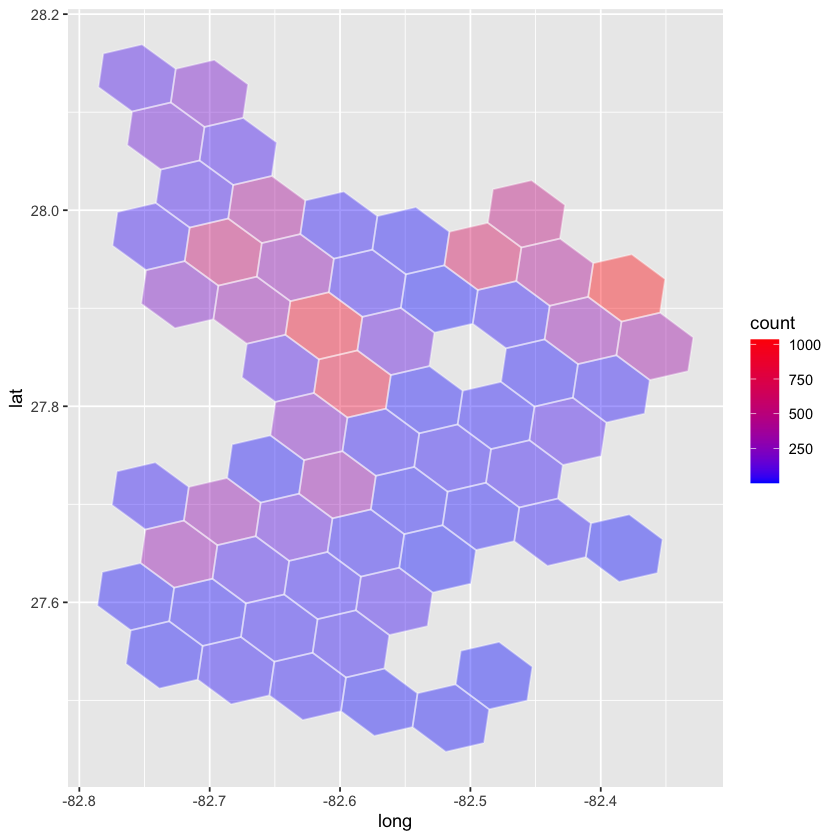

In [8]:
# Plot it
p<- ggplot() + 
  geom_polygon(data=grid, aes(x=long, y=lat, group=group, fill=count), alpha=0.4)    +
  geom_path   (data=grid, aes(x=long, y=lat, group=group), alpha=0.4, color="white") +
  scale_fill_gradient(low="blue", high="red")
p

In [ ]:
# Where to save results
data_dir <- r""
shp_out <- paste(data_dir, "station_hex.shp", sep='/')
# Get cell boundary to save
dgcellstogrid(dggs, counts$cell,frame=FALSE,savegrid=data_dir)
# Export grid to shp
grid.sf <- st_as_sf(grid, coords = c("long", "lat"), crs=st_crs(station.sf))
st_write(grid.sf, shp_out)